In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import seaborn as sns
import gcsfs
from pathlib import Path
import yaml
#cartopy text scale issues
sns.set_context('paper', font_scale=.9)

cartopy 0.17.0


### setup data access

In [2]:
gcsfs.core.client_config['installed']['client_id'] = '160816776314-7h1p2h6bqhe77vs1su4rr22fblso9dre.apps.googleusercontent.com'
gcsfs.core.client_config['installed']['client_secret'] = 'SrJUwD58yKgViyJtw-NP2sz8'

In [3]:
# create a GCSFileSystem just for the purpose of authentication
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# create another one with those credentials
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials, cache_timeout=0)

### setup data

In [4]:
staging_dir = Path("vo_agam_staging")
species_analysis = "species_calls_20200422"

In [5]:
with open("../data/config.yml", "r") as yy:
    config = yaml.load(yy, Loader=yaml.Loader)

samplesets = sorted(config["sample_sets"])

#GA-B is empty, crosses we don't want
samplesets.remove('AG1000G-GA-B')
samplesets.remove('AG1000G-X')

In [6]:
samplesets

['AG1000G-AO',
 'AG1000G-BF-A',
 'AG1000G-BF-B',
 'AG1000G-BF-C',
 'AG1000G-CD',
 'AG1000G-CF',
 'AG1000G-CI',
 'AG1000G-CM-A',
 'AG1000G-CM-B',
 'AG1000G-CM-C',
 'AG1000G-FR',
 'AG1000G-GA-A',
 'AG1000G-GH',
 'AG1000G-GM-A',
 'AG1000G-GM-B',
 'AG1000G-GM-C',
 'AG1000G-GN-A',
 'AG1000G-GN-B',
 'AG1000G-GQ',
 'AG1000G-GW',
 'AG1000G-KE',
 'AG1000G-ML-A',
 'AG1000G-ML-B',
 'AG1000G-MW',
 'AG1000G-MZ',
 'AG1000G-TZ',
 'AG1000G-UG']

In [7]:
#need to get mean lon/lat across countries so we might as well concat all metadata including species into a big PD

set_len = 0
all_meta = pd.DataFrame()

for sset in samplesets:
        
        metadata_path = staging_dir / "v3" / "metadata" / "general" / sset / "samples.meta.csv"
        species_path = staging_dir / "v3" / "metadata" / species_analysis / sset / "samples.species_aim.csv"


        with gcs.open(metadata_path) as gcs_fh:
            df = pd.read_csv(gcs_fh, index_col=0)
        with gcs.open(species_path) as gcs_fh:
            df_aim = pd.read_csv(gcs_fh, index_col=0)

        # join on sample id
        result = pd.concat([df, df_aim], axis=1, sort=False)
        set_len += len(result)

        all_meta = pd.concat([all_meta, result],sort=False)

assert len(all_meta) == set_len

In [8]:
all_meta


,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii
sample_id,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.945,0.001,gamb_colu,coluzzii
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.933,0.001,gamb_colu,coluzzii
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.937,0.002,gamb_colu,coluzzii
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.938,0.002,gamb_colu,coluzzii
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,0.926,0.001,gamb_colu,coluzzii
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC0295-C,K92,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,0.026,0.002,gamb_colu,gambiae
AC0296-C,K93,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,0.029,0.003,gamb_colu,gambiae
AC0297-C,K94,Martin Donnelly,Uganda,Kihihi,2012,11,-0.751,29.701,F,0.026,0.002,gamb_colu,gambiae


In [9]:
q = all_meta.species_gambcolu_arabiensis.value_counts()
q

gamb_colu       2415
arabiensis       368
intermediate       1
Name: species_gambcolu_arabiensis, dtype: int64

In [10]:
len(all_meta)

2784

In [11]:
s = all_meta[all_meta.country == "Uganda"].species_gambcolu_arabiensis.value_counts()
p = all_meta[all_meta.country == "Uganda"].species_gambiae_coluzzii.value_counts()

In [12]:
s

gamb_colu       207
arabiensis       82
intermediate      1
Name: species_gambcolu_arabiensis, dtype: int64

In [13]:
p

gambiae    207
Name: species_gambiae_coluzzii, dtype: int64

In [14]:
all_meta.species_gambiae_coluzzii.unique()

array(['coluzzii', 'gambiae', 'intermediate', nan], dtype=object)

In [15]:
samplesets

['AG1000G-AO',
 'AG1000G-BF-A',
 'AG1000G-BF-B',
 'AG1000G-BF-C',
 'AG1000G-CD',
 'AG1000G-CF',
 'AG1000G-CI',
 'AG1000G-CM-A',
 'AG1000G-CM-B',
 'AG1000G-CM-C',
 'AG1000G-FR',
 'AG1000G-GA-A',
 'AG1000G-GH',
 'AG1000G-GM-A',
 'AG1000G-GM-B',
 'AG1000G-GM-C',
 'AG1000G-GN-A',
 'AG1000G-GN-B',
 'AG1000G-GQ',
 'AG1000G-GW',
 'AG1000G-KE',
 'AG1000G-ML-A',
 'AG1000G-ML-B',
 'AG1000G-MW',
 'AG1000G-MZ',
 'AG1000G-TZ',
 'AG1000G-UG']

In [16]:
countries = list(all_meta.country.unique())
countries

['Angola',
 'Burkina Faso',
 'Democratic Republic of Congo',
 'Central African Republic',
 "Cote d'Ivoire",
 'Cameroon',
 'Mayotte',
 'Gabon',
 'Ghana',
 'Gambia, The',
 'Guinea',
 'Mali',
 'Equatorial Guinea',
 'Guinea-Bissau',
 'Kenya',
 'Malawi',
 'Mozambique',
 'Tanzania',
 'Uganda']

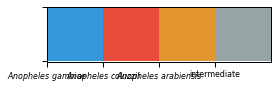

In [36]:
sp_nm = ['$Anopheles$ $gambiae$', '$Anopheles$ $coluzzii$', '$Anopheles$ $arabiensis$', 'intermediate']
#palette
flat = ["#3498db", "#e74c3c", "#e2962d", "#95a5a6"]
palette = sns.color_palette(flat, n_colors=len(sp_nm))
# add a colour for other_resistant
sns.palplot(palette)
plt.gca().set_xticklabels(sp_nm);

In [47]:
for c in countries:
    df = all_meta[all_meta.country == c]
    ar = 0
    gm = 0
    cl = 0
    it = 0
    #species counts
    spai = df.species_gambcolu_arabiensis.value_counts()
    if 'arabiensis' in spai:
        ar += spai.arabiensis
    if 'intermediate' in spai:
        it += spai.intermediate
        
    spgc = df.species_gambiae_coluzzii.value_counts()
    if 'gambiae' in spgc:
        gm += spgc.gambiae
    if 'intermediate' in spgc:
        it += spgc.intermediate
    if 'coluzzii' in spgc:
        cl += spgc.coluzzii
    
    #check
    tot = ar + gm + cl + it
    assert(tot == len(df))
    print(c, ar, gm, cl, it)

Angola 0 0 81 0
Burkina Faso 3 157 135 1
Democratic Republic of Congo 0 76 0 0
Central African Republic 0 55 18 0
Cote d'Ivoire 0 0 80 0
Cameroon 2 416 26 0
Mayotte 0 23 0 0
Gabon 0 69 0 0
Ghana 0 36 64 0
Gambia, The 0 69 169 41
Guinea 0 123 11 2
Mali 2 131 91 1
Equatorial Guinea 0 10 0 0
Guinea-Bissau 0 29 0 72
Kenya 13 28 0 45
Malawi 41 0 0 0
Mozambique 0 74 0 0
Tanzania 225 68 0 7
Uganda 82 207 0 1


In [38]:
tot

290

In [31]:
len(all_meta)

2784

In [52]:
#code to get a single averaged lat/lon and species composition for each country
def plot_pyr_map(dpi=150, extent=[-22, 48, -25, 15], figsize=(10, 4), label_fontsize=7):
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=120)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=1, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=5)
    
    for c in countries:
        df = all_meta[all_meta.country == c]
        ar = 0
        gm = 0
        cl = 0
        it = 0
        #species counts
        spai = df.species_gambcolu_arabiensis.value_counts()
        if 'arabiensis' in spai:
            ar += spai.arabiensis
        if 'intermediate' in spai:
            it += spai.intermediate

        spgc = df.species_gambiae_coluzzii.value_counts()
        if 'gambiae' in spgc:
            gm += spgc.gambiae
        if 'intermediate' in spgc:
            it += spgc.intermediate
        if 'coluzzii' in spgc:
            cl += spgc.coluzzii

        #check
        tot = ar + gm + cl + it
        assert(tot == len(df))
        
        #get an average lonlat for each country
        lon = np.mean(df.longitude.unique())
        lat = np.mean(df.latitude.unique())

        centre = (lon, lat)
        radius=2
        ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=0.4))
        ax.pie([gm, cl, ar, it], wedgeprops=dict(zorder=7), colors=palette, center=centre, radius=radius, shadow=True)
        
    ax.set_extent(extent)         


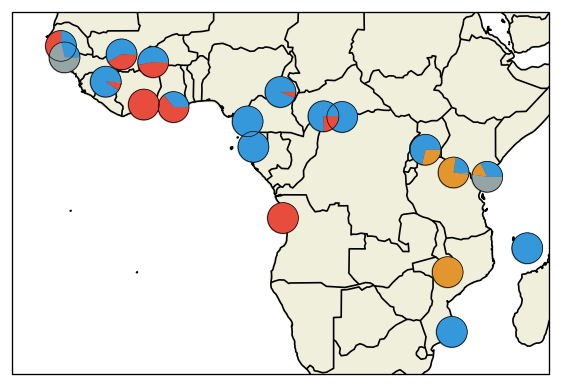

In [53]:
plot_pyr_map()

In [17]:
#sex as well as species?